# Using the life-table QALY model

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2022 by BIOMATH, Ghent University. All Rights Reserved.

In [1]:
#############################
## Load necessary packages ##
#############################

import datetime
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import output_to_visuals
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.models.QALY import life_table_QALY_model, lost_QALYs_hospital_care

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Define the settings

In [2]:
################################
## Define simulation settings ##
################################

# Number of simulations
N=18
# Number of neg. binomial draws/ simulation
K=10
# Number of cpu's
processes=18
# Number of age groups
age_stratification_size=10
# End of simulation
end_sim='2021-07-01'
# Confidence level used to visualise model fit
conf_int=0.05

##########################
## Define QALY settings ##
##########################

r=0.03

## Step 1: setup the national COVID-19 SEIQRD model

In [13]:
##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
df_cases = df_cases.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# Deaths in hospitals
df_sciensano_mortality = sciensano.get_mortality_data()
deaths_hospital = df_sciensano_mortality.xs(key='all', level="age_class", drop_level=True)['hospital','cumsum']

##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size)

warmup = float(BASE_samples_dict['warmup'])
dispersion = float(BASE_samples_dict['dispersion'])
start_sim = BASE_samples_dict['start_calibration']

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fcn

In [14]:
#########################
## Perform simulations ##
#########################

print('\n1) Simulating COVID19_SEIQRD_hybrid_vacc '+str(N)+' times')
out = model.sim(end_sim,start_date=start_sim, warmup=warmup, processes=processes, N=N, draw_fcn=draw_fcn, samples=BASE_samples_dict)


1) Simulating COVID19_SEIQRD_hybrid_vacc 18 times


## Step 2: Setup the QALY model

[<img align="left" src="briggs_count_the_cost_of_disability_caused_by_COVID-19.jpg" width="400"/>](briggs_count_the_cost_of_disability_caused_by_COVID-19.jpg)

In [15]:
# Define a dataframe with the comorbidity characteristics of group 2 and group 3 in above figure
# Group 2: SMR=1 (no change of life-expectancy) but the QoL is reduced by 0.10 for the rest of the lifetime
# Group 3: SMR=2 (roughly 7 year reduction of life-expectancy) and the QoL is reduced by 0.10 for the rest of the lifetime
iterables = [pd.IntervalIndex.from_tuples([(0,120),], closed='left'),['delta_QoL', 'SMR']]
index = pd.MultiIndex.from_product(iterables, names=['age_group', 'metric'])
comorbidity_parameters = pd.DataFrame(index=index, columns=['LC2','AD3'])
comorbidity_parameters.columns.name = 'population'
comorbidity_parameters.loc[(slice(None),'SMR'),:] = [1, 2]
comorbidity_parameters.loc[(slice(None),'delta_QoL'),:] = [-0.10, -0.20]
print(comorbidity_parameters)

population           LC2  AD3
age_group metric             
[0, 120)  delta_QoL -0.1 -0.2
          SMR          1    2


In [16]:
# Initialize the life table QALY model
QALY_model = life_table_QALY_model(comorbidity_parameters)

## Step 4: Perform ex-ante QALY calculation

### Examples of health economic costs

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4690729/ --> Table A2 --> utility weight = 0.659

https://www.valueinhealthjournal.com/article/S1098-3015(21)00034-6/fulltext --> Table 2 --> 1-0.43=0.57

In [17]:
def append_QALY_D(out, QALY_binned):
    """QALYs lost to COVID-19 deaths"""
    out['QALY_D'] = out['D']*np.array(QALY_binned)[np.newaxis,:,np.newaxis,np.newaxis]
    return out

def append_QALY_M(out, delta_QoL):
    """QALYs lost to symptomatic COVID-19 (wo hospitalization)"""
    out['QALY_M'] = out['M_in'].cumsum(dim='time')*(model.parameters['dm']/365)*delta_QoL
    return out

def append_QALY_LC1(out, f_LC, horizon_LC, delta_QoL):
    """QALYs lost to type 1 long-COVID"""
    out['QALY_LC1'] = f_LC*out['M_in'].cumsum(dim='time')*horizon_LC*delta_QoL
    return out

def append_QALY_LC2(out, f_LC, QALY_binned):
    """QALYs lost to type 2 long-COVID"""
    out['QALY_LC2'] = f_LC*out['M_in'].cumsum(dim='time')*np.array(QALY_binned)[np.newaxis,:,np.newaxis,np.newaxis]
    return out

def append_QALY_AD(out, f_LC, QALY_binned):
    """QALYs lost to life-long acquired disability reducing life expectancy"""
    out['QALY_AD'] = f_LC*out['H_in'].cumsum(dim='time')*np.array(QALY_binned)[np.newaxis,:,np.newaxis,np.newaxis]
    return out

In [18]:
# QALY reduction of 0.15 during duration of disease
out = append_QALY_M(out, 0.15)
# 10% of mildly infected experience QoL reduction of 0.10 over two years
out = append_QALY_LC1(out, 0.10, 2, 0.10)
# QALYs lost to COVID-19 death
QALY_binned_BE = QALY_model.bin_QALY_x(QALY_model.compute_QALY_x(r=r))
out = append_QALY_D(out, QALY_binned_BE)
# 5% of mildly infected experiences QoL reduction of 0.10 for rest of life
QALY_binned_LC2 = QALY_model.bin_QALY_x(QALY_model.compute_QALY_x(population='LC2', r=r, SMR_method='constant'))
out = append_QALY_LC2(out, 0.05, QALY_binned_BE - QALY_binned_LC2)
# 10% of hospitalized patients experience QoL reduction of 0.20 and 7 years reduction of life span
QALY_binned_AD3 = QALY_model.bin_QALY_x(QALY_model.compute_QALY_x(population='AD3', r=r, SMR_method='constant'))
out = append_QALY_AD(out, 0.10, QALY_binned_BE - QALY_binned_AD3)

## Step 5: Visualize different forms of QALY loss

2) Visualizing fit


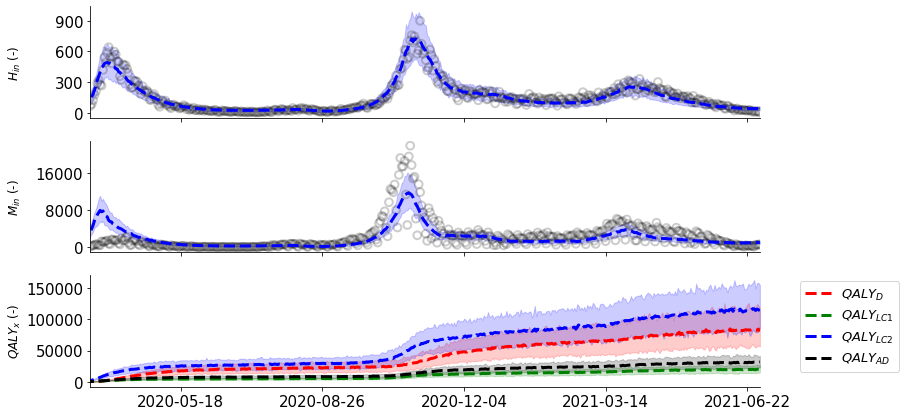

In [29]:
df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'M_in', 'D', 'QALY_D', 'QALY_M', 'QALY_LC1', 'QALY_LC2', 'QALY_AD'], alpha=dispersion, n_draws_per_sample=K, UL=1-conf_int*0.5, LL=conf_int*0.5)
simtime = out['time'].values

#######################
## Visualize results ##
#######################

print('2) Visualizing fit')

# Plot hospitalizations
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(12,7))
ax1.plot(df_2plot['H_in','mean'],'--', color='blue')
ax1.fill_between(simtime, df_2plot['H_in','lower'], df_2plot['H_in','upper'],alpha=0.20, color = 'blue')
ax1.scatter(df_hosp[start_sim:end_sim].index,df_hosp['H_in'][start_sim:end_sim], color='black', alpha=0.2, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1 = _apply_tick_locator(ax1)
ax1.set_xlim(start_sim,end_sim)
ax1.set_ylabel('$H_{in}$ (-)', fontsize=12)
ax1.get_yaxis().set_label_coords(-0.1,0.5)
ax1.grid(False)

# Plot number of mildly infected
ax2.plot(df_2plot['M_in','mean'],'--', color='blue')
ax2.fill_between(simtime, df_2plot['M_in','lower'], df_2plot['M_in','upper'],alpha=0.20, color = 'blue')
ax2.scatter(df_cases[start_sim:end_sim].index,df_cases[start_sim:end_sim], color='black', alpha=0.2, linestyle='None', facecolors='none', s=60, linewidth=2)
ax2 = _apply_tick_locator(ax2)
ax2.set_xlim(start_sim,end_sim)
ax2.set_ylabel('$M_{in}$ (-)', fontsize=12)
ax2.get_yaxis().set_label_coords(-0.1,0.5)
ax2.grid(False)

# Plot QALY losses
ax3.plot(df_2plot['QALY_D','mean'],'--', color='red')

ax3.plot(df_2plot['QALY_LC1','mean'],'--', color='green')
ax3.plot(df_2plot['QALY_LC2','mean'],'--', color='blue')
ax3.plot(df_2plot['QALY_AD','mean'],'--', color='black')

ax3.fill_between(simtime, df_2plot['QALY_D','lower'], df_2plot['QALY_D','upper'],alpha=0.20, color = 'red')
ax3.fill_between(simtime, df_2plot['QALY_LC1','lower'], df_2plot['QALY_LC1','upper'],alpha=0.20, color = 'green')
ax3.fill_between(simtime, df_2plot['QALY_LC2','lower'], df_2plot['QALY_LC2','upper'],alpha=0.20, color = 'blue')
ax3.fill_between(simtime, df_2plot['QALY_AD','lower'], df_2plot['QALY_AD','upper'],alpha=0.20, color = 'black')

ax3 = _apply_tick_locator(ax3)
ax3.set_xlim(start_sim,end_sim)
ax3.set_ylabel('$QALY_x$ (-)', fontsize=12)
ax3.get_yaxis().set_label_coords(-0.1,0.5)
ax3.legend(['$QALY_D$', '$QALY_{LC1}$', '$QALY_{LC2}$', '$QALY_{AD}$'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax3.grid(False)

plt.show()
plt.close()

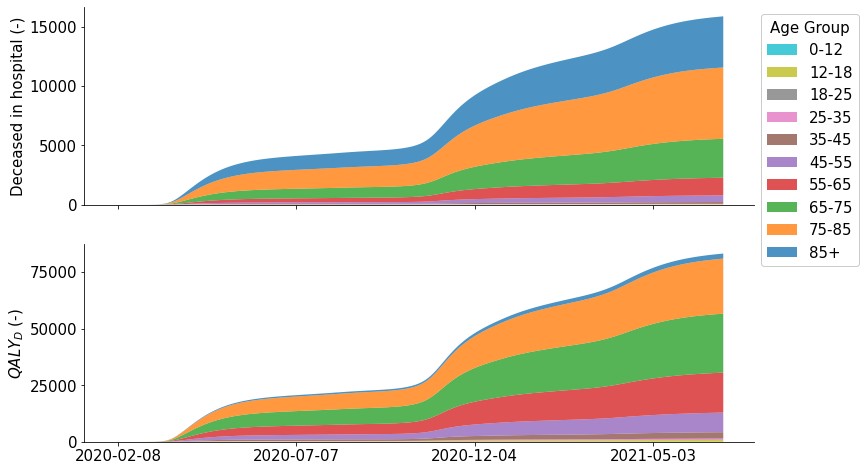

In [20]:
#Plot

Palette=cm.get_cmap('tab10_r', initN.size).colors
age_group=['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']

fig, axs = plt.subplots(2,figsize=(12,8),sharex=True)

axs[0].stackplot(out['time'].values,out['D'].mean(dim='draws').sum(dim='doses').values, labels=age_group, colors=Palette, alpha=0.8)
axs[0].legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1))  
axs[0] = _apply_tick_locator(axs[0])
axs[0].set_ylabel('Deceased in hospital (-)')
axs[0].grid(False)

axs[1].stackplot(simtime,out['QALY_D'].mean(dim="draws").sum(dim='doses'),linewidth=3, labels=age_group, colors=Palette, alpha=0.8)
axs[1].set_ylabel('$QALY_D$ (-)')
axs[1] = _apply_tick_locator(axs[1])
axs[1].grid(False)

states = ['QALYs_death','QALYs_treatment']
title = ['QALYs lost to COVID-19 death', 'QALYs gained by treating COVID-19']
ylabel = ['lost QALYs','gained QALYs']

#plt.savefig('../../results/QALYs/QALYs_lost.png',bbox_inches='tight',dpi=300)

## Step 6: Compare to postponement of non-COVID-19 care

### A simple comparison

In [21]:
# Extract the daily QALY loss if care is reduced uniformely by 15%
reduction=0.15
lost_QALYs_hospital_care_data=lost_QALYs_hospital_care(reduction)
# Multiply with a lockdown of 63 days during the first COVID-19 wave and 
lockdown_days=63
QALY_loss = lockdown_days*lost_QALYs_hospital_care_data
print(f'Approximately {int(QALY_loss)} QALYs were lost if non-COVID-19 care was reduced by {int(100*reduction)}% over {lockdown_days} days')

Approximately 18593 QALYs were lost if non-COVID-19 care was reduced by 15% over 63 days


### A more elaborate comparison

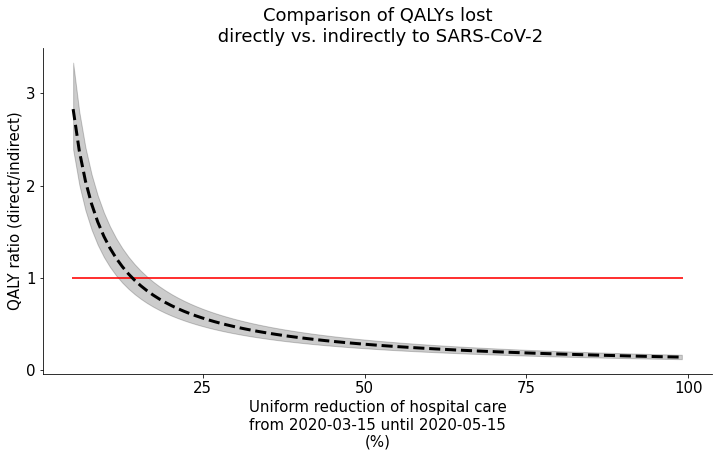

In [22]:
# Define percentual reduction range
reduction_range=np.linspace(0.05,0.99,100)
# Calculate QALYs lost due to hospital care reduction
lost_hospital=lost_QALYs_hospital_care(reduction_range)
# Calculate how much QALYs are lost over a time period delta_T
start_lockdown = '2020-03-15'
end_lockdown = '2020-05-15'
delta_T = (pd.to_datetime(end_lockdown) - pd.to_datetime(start_lockdown))/pd.Timedelta(days=1)
QALY_indirect = lost_hospital*delta_T
# Extract direct QALY loss from model
QALY_D_mean = out['QALY_D'].sel(time=end_lockdown).sum(dim=['doses', 'Nc']).mean(dim='draws').data
QALY_D_upper = out['QALY_D'].sum(dim=['doses', 'Nc']).sel(time=end_lockdown).quantile(dim='draws',q=0.975).data
QALY_D_lower = out['QALY_D'].sum(dim=['doses', 'Nc']).sel(time=end_lockdown).quantile(dim='draws',q=0.025).data
# Calculate ratio
ratio_mean = QALY_D_mean/QALY_indirect
ratio_upper = QALY_D_lower/QALY_indirect
ratio_lower = QALY_D_upper/QALY_indirect

# Initialize plot
fig,ax = plt.subplots(figsize=(12,6))
# Add lines
ax.plot(reduction_range*100,np.ones(100),color='red',alpha=0.8,linewidth=2)
ax.plot(reduction_range*100,ratio_mean,'--',color='black')
ax.fill_between(reduction_range*100,ratio_lower,ratio_upper,alpha=0.2,color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.grid(False)
# labels and title
ax.set_xlabel('Uniform reduction of hospital care\nfrom 2020-03-15 until 2020-05-15\n(%)')
ax.set_ylabel('QALY ratio (direct/indirect)')
plt.title('Comparison of QALYs lost\n directly vs. indirectly to SARS-CoV-2')
plt.show()
plt.close()